# 6.6: Sourcing & Analyzing Time Series Data

### The script contain the following points:

1a)Importing libraries to computer

1b)Importing Data to Notebook / Turning Project Folder Path Into a String (NHL Players Dataset)

2)Data Check/Cleaning/Subset

3)Line Chart

4)Time-Series Analysis: Decomposition

5)Testing For Stationarity

6)Autocorrelation

7)Stationarizing the 'nhl_max' Dataset

## 1a.Importing libraries to computer 

In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

#### Did not install Quandl library since my dataset already contained time series data

## 1b. Importing Data to Notebook / Turning Project Folder Path Into a String (NHL Players Dataset)

In [2]:
# Creating a data importing shortcut called 'path' for the NHL project folder to make importing data easier and cleaner
path =r'/Users/drewsmith/Desktop/NHL Player Stats Analysis'

In [3]:
# Utilizing the newly created 'path' shortcut to import the 'NHL Player Data' dataset
nhl_df = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'nhl_states_prov1.csv'), index_col = False)

## 02. Data Check/Cleaning/Subset

In [4]:
nhl_df.shape

(12270, 31)

In [5]:
nhl_df.head()

,Unnamed: 0,Season,Rank,Player,Age,Position,Team,State_Province,Games_Played,Goals,...,Time_On_Ice,Playtime_Status,Avg_Time_On_Ice,Blocks,Hits,Faceoff_Wins,Faceoff_Losses,Faceoff_Percentage,Hart_Trophy?,Votes
0,0,2017,1,Connor McDavid\mcdavco01,20,C,EDM,Alberta,82,30,...,1733,Top Minutes,21.133333,29.0,34,348.0,458.0,43.2,Yes,1604
1,1,2017,2,Sidney Crosby\crosbsi01,29,C,PIT,Pennsylvania,75,44,...,1491,Lots of Playtime,19.883333,27.0,80,842.0,906.0,48.2,No,1104
2,2,2017,3,Patrick Kane\kanepa01,28,RW,CHI,Illinois,82,34,...,1754,Top Minutes,21.400000,15.0,28,7.0,44.0,13.7,No,206
3,3,2017,4,Nicklas Backstrom\backsni02,29,C,WSH,Virginia,82,23,...,1497,Lots of Playtime,18.266667,33.0,45,685.0,648.0,51.4,No,60
4,4,2017,5,Nikita Kucherov\kucheni01,23,RW,TBL,Florida,74,40,...,1438,Lots of Playtime,19.433333,20.0,30,0.0,0.0,0.0,No,119


In [6]:
# Dropping this column since it is unnecessary 
nhl_df = nhl_df.drop(columns = ['Unnamed: 0'])

In [7]:
# Doesn't assign any options to the max number of columns so functions can display all columns
pd.options.display.max_columns = None

### Making a Subset

In [177]:
# Creating subset 
nhl_points1 = nhl_df[['Season','Points']]

In [178]:
nhl_points1.head()

,Season,Points
0,2017,100
1,2017,89
2,2017,89
3,2017,86
4,2017,85


In [205]:
nhl_points1.dtypes

Points    int64
dtype: object

In [211]:
nhl_points1.reset_index(inplace= True)

In [189]:
nhl_points1['Season'] = nhl_points1['Season'].astype(str)

In [204]:
nhl_points1['Points'] = nhl_points1['Points'].astype(int)

In [215]:
nhl_points1.set_index('Season', inplace= True)

In [216]:
nhl_points1.head()

,Points
Season,
2017,100
2017,89
2017,89
2017,86
2017,85


In [206]:
nhl_max = (nhl_points1.groupby('Season').max())

In [214]:
nhl_max

,Points
Season,
2006,125
2007,120
2008,112
2009,120
2010,112
2011,104
2012,109
2013,60
2014,104


In [208]:
nhl_max.dtypes

Points    int64
dtype: object

#### I changed the inputs for the 'Points' column to maximum points for that season since no months or days were included in the dataset. All inputs fell under each season which means the time series analysis was not going to not work unless I used one specific value per season.  Since these are final point totals after a season is completed, there isn't a more specific date you can analyze besides year. I chose the max amount of points per season because it answers part a previously asked question, "Which seasons or teams have seen the highest goals, assists, points and the lowest in the dataset’s timeframe?"

## 03. Line Chart

In [217]:
nhl_max.reset_index(inplace= True)

In [220]:
# Set the "Season" column as the index

from datetime import datetime

nhl_max['Year'] = pd.to_datetime(nhl_max['Season']) # Create a datetime column from "Date.""
nhl_max = nhl_max.set_index('Year') # Set the datetime as the index of the dataframe.
nhl_max.drop(['Season'], axis=1, inplace=True) # Drop the "Date" column.
nhl_max.head()

,Points
Year,
2006-01-01,125
2007-01-01,120
2008-01-01,112
2009-01-01,120
2010-01-01,112


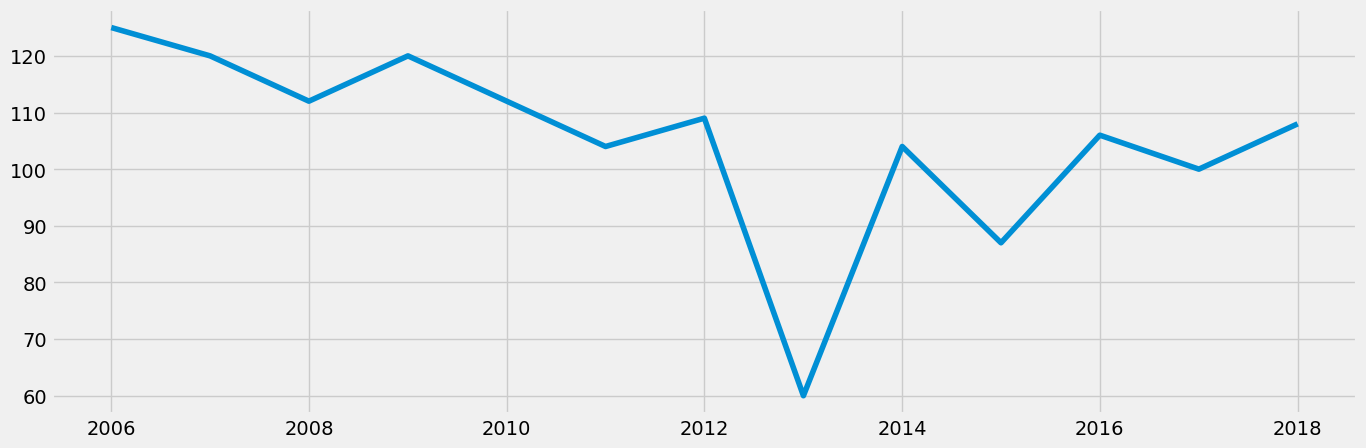

In [221]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(nhl_max)

In [110]:
# Check for missing values 
nhl_max.isnull().sum() 

Points    0
dtype: int64

## 04. Time-Series Analysis: Decomposition

In [222]:
# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(nhl_max, model='additive')

In [223]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

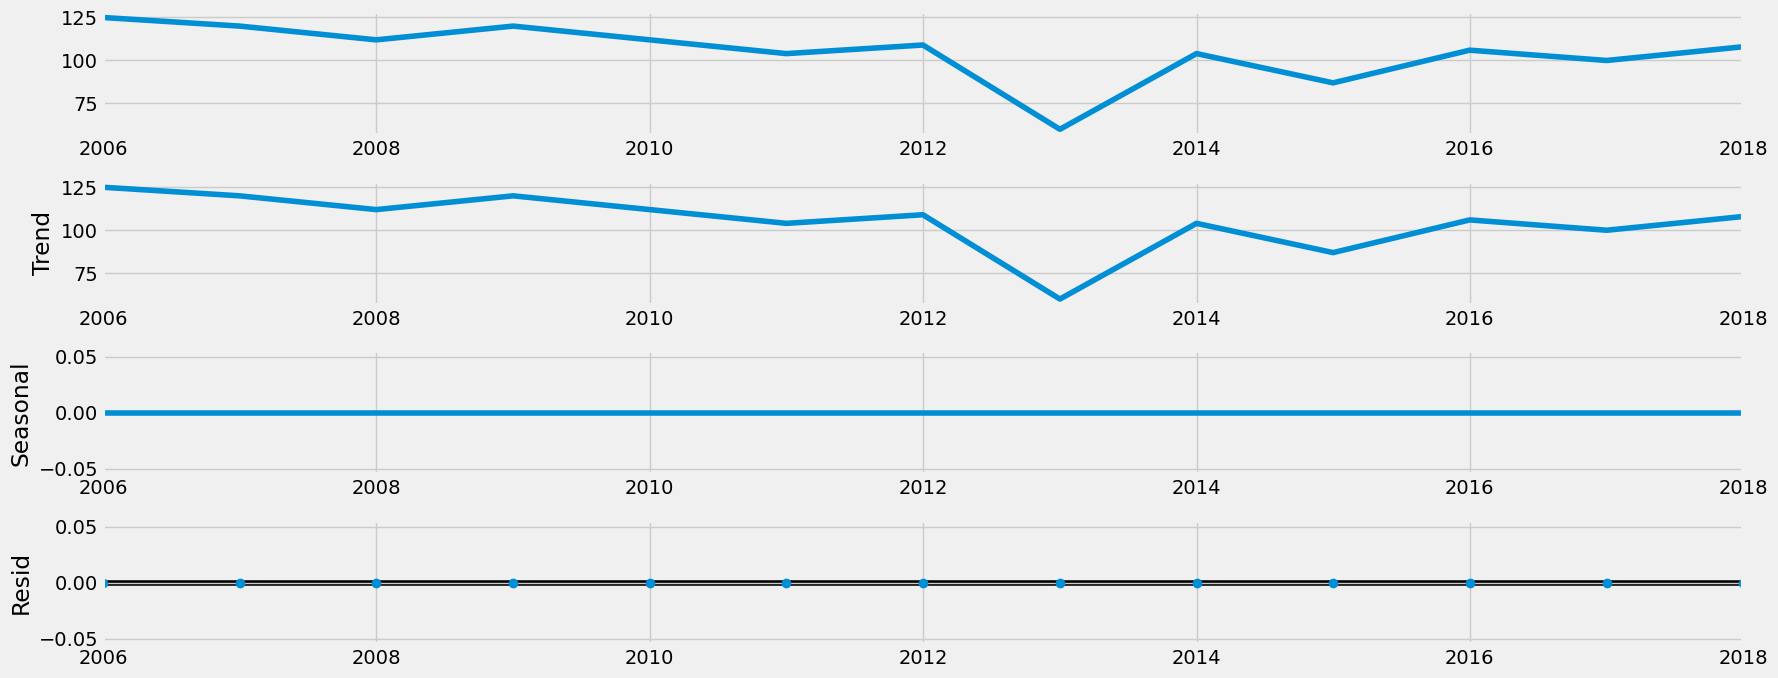

In [224]:
# Plot the separate components

decomposition.plot()
plt.show()

#### Results: The level and underlying trend lines are the same. The seasonal line is flat since there is not seasonality within this dataset. The dataset is player statistics after a season is completed which only needs the year to categorize. The residual line has one datapoint each year and is flat. 

## 05. Testing For Stationarity

In [225]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(nhl_max['Points'])

Dickey-Fuller Stationarity test:
Test Statistic                 -2.958441
p-value                         0.038962
Number of Lags Used             0.000000
Number of Observations Used    12.000000
Critical Value (1%)            -4.137829
Critical Value (5%)            -3.154972
Critical Value (10%)           -2.714477
dtype: float64


#### Results: The test statistic is smaller than the critical value of 10% which means I can reject the hypothesis and the data is stationary. However, the test statistic is larger than the critical value of 5% and 1% which means I cannot reject the null hypothesis. This means there is a unit root in the data and the data is non-stationary.  

#### The null hypothesis is that there’s is a unit root and the data is non-stationary. The alternative hypothesis is that there’s no unit root and the data is stationary.

## 06. Autocorrelation

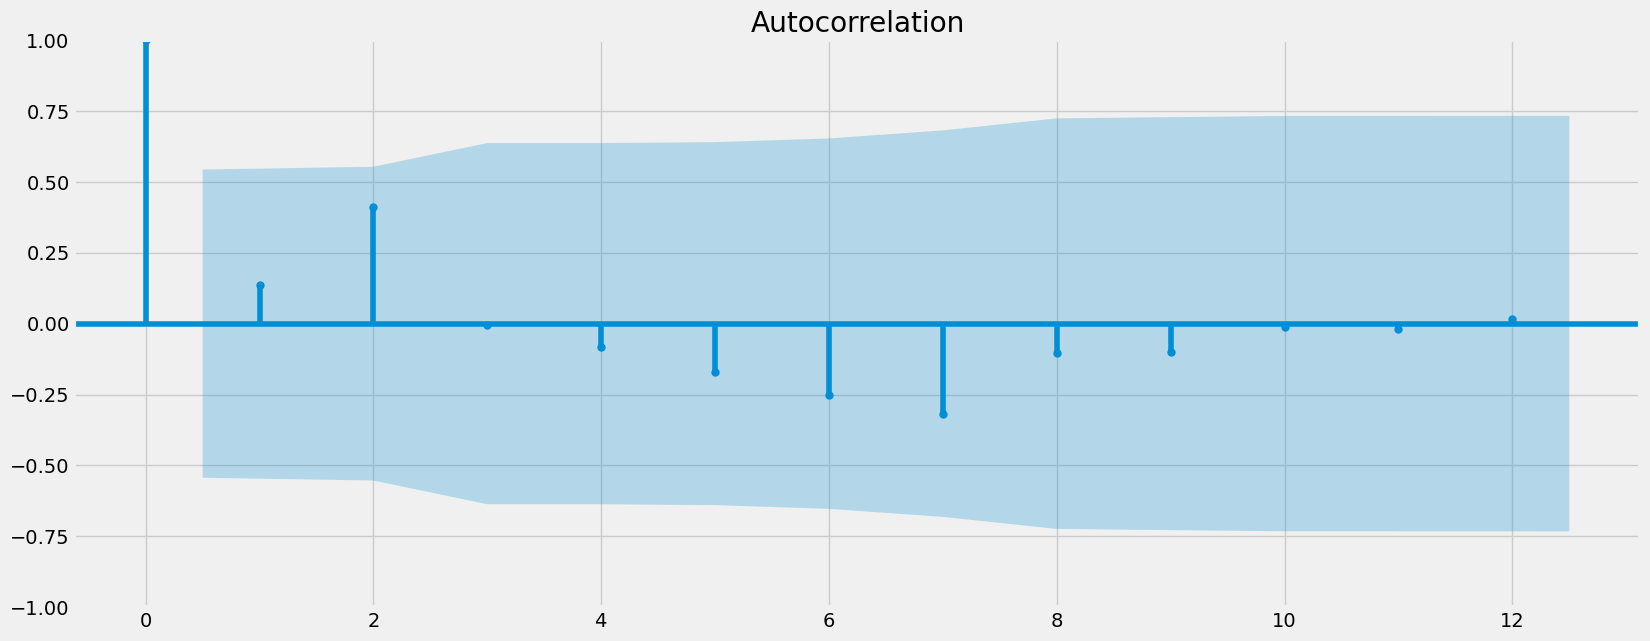

In [226]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(nhl_max)
plt.show()

## 07. Stationarizing the 'nhl_max' Dataset

In [326]:
# The df.shift(9) function turns the observation to t-9, making the whole thing t - (t -9)
nhl_diff = nhl_max - nhl_max.shift(9) 

In [327]:
# Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.
nhl_diff.dropna(inplace = True) 

In [328]:
nhl_diff.head()

,Points
Year,
2015-01-01,-38.0
2016-01-01,-14.0
2017-01-01,-12.0
2018-01-01,-12.0


In [329]:
nhl_diff.columns

Index(['Points'], dtype='object')

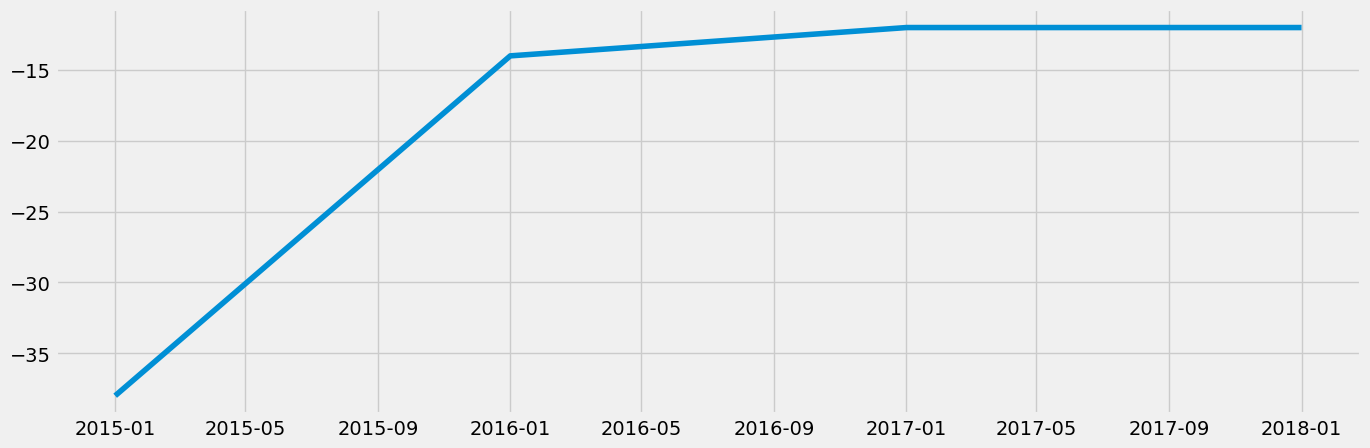

In [330]:
# Check out what the differencing did to the time-series curve
plt.figure(figsize=(15,5), dpi=100)
plt.plot(nhl_diff)

In [331]:
dickey_fuller(nhl_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -166.854228
p-value                          0.000000
Number of Lags Used              0.000000
Number of Observations Used      3.000000
Critical Value (1%)            -10.417191
Critical Value (5%)             -5.778381
Critical Value (10%)            -3.391681
dtype: float64


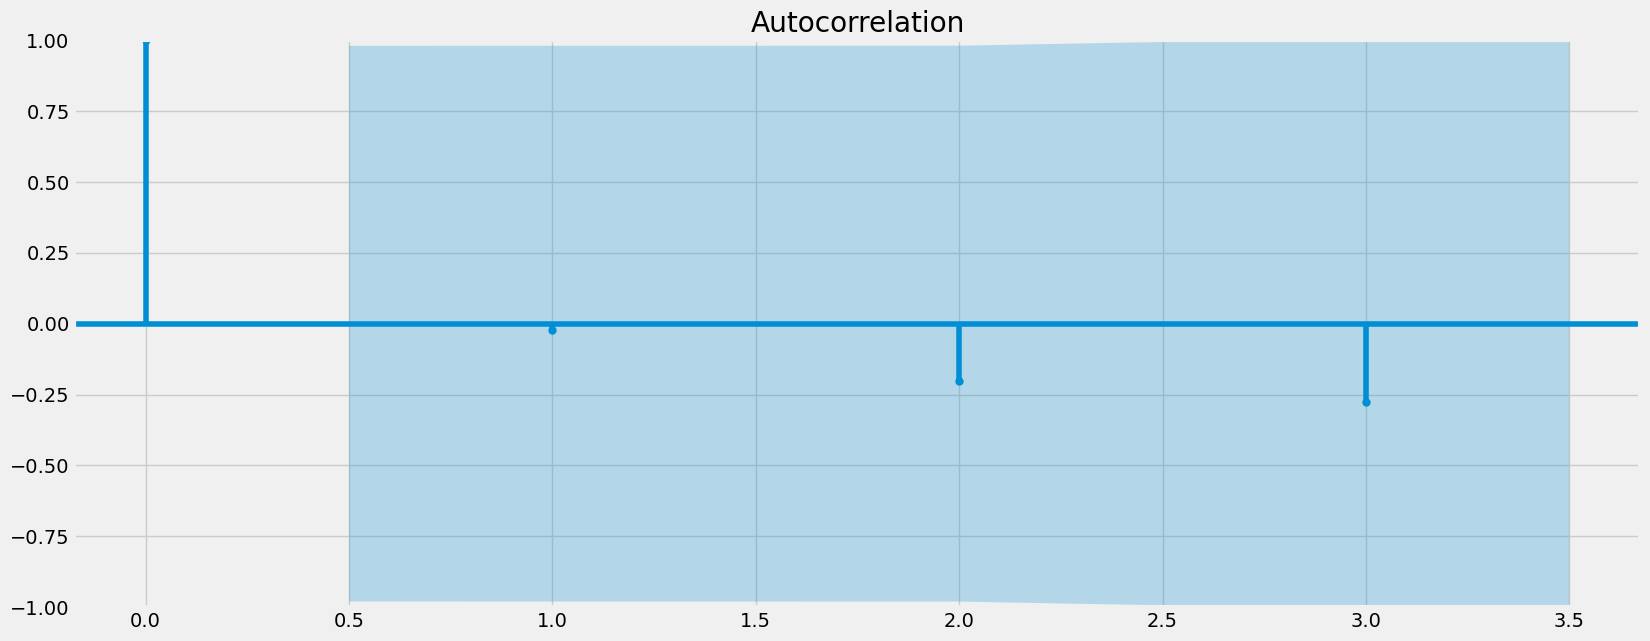

In [332]:
plot_acf(nhl_diff)
plt.show()

#### I tried a variety of differencing by changing the shift input from 1-8 but 9 was the only one that resulted in the test-statistic being smaller that all the critical values. The test-statistic ended up being much smaller than the critical values.